# 2024-1 DSL 정규세션 과제

## CNN Assignment

- 작성자 : 윤형진
- 참고자료 : PyTorch Document
- 과제 제출 기한 : 02.18

---
- 이름 : 김영호
- 기수 : 10기    



In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 257.9/257.9 kB 24.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.8 MB/s eta 0:00:00


In [2]:
# colab 환경에서 학습을 진행하실 분들은 구글드라이브를 연동해주세요
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
import numpy as np

import yaml
import os

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F

from torchvision import transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

In [4]:
import os
import pandas as pd
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor

from PIL import Image

"""
MetaData.csv를 나누어 만든 train, val, test 데이터프레임에 담긴 이미지와 레이블을 반환해주는 CustomImageDataset을 만들어주세요
참고자료 : https://pytorch.org/tutorials/beginner/data_loading_tutorial.html
"""

class CustomImageDataset(Dataset):

    def __init__(self, dataset_direc:str, df:pd.DataFrame, transform = None) -> None:

        # 3000개의 이미지를 담고있는 DataSet 디렉토리의 경로입니다.
        self.dataset_direc= dataset_direc

        self.df = df.reset_index(drop=True)

        self.to_tensor = ToTensor() # 파이토치에서는 모든 인풋을 torch.Tensor()로 바꿔줘야합니다.

        self.transform = transform

    # __init__() 함수에서 받은 데이터프레임에 포함된 전체 데이터포인트의 수를 반환하도록 해주세요
    def __len__(self) -> int :
        return len(self.df)


    def __getitem__(self, idx:int):
        # __init__() 함수에서 받은 데이터프레임의 각 행에서 받은 FileName, StrLabel, self.dataset_direc, Label을 이용해 이미지 데이터와 레이블을 반환해주세요

        data = self.df.iloc[idx]
        image = Image.open(os.path.join(self.dataset_direc, data['StrLabel'], data['FileName']))
        label = data['Label']

        image = self.to_tensor(image)

        if self.transform:
            image = self.transform(image)

        return image, label

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np

"""
[Batch, Channel, 224, 224]의 input을 받았을 때,
최종적으로 sigmoid activation function에 들어갈 값을 반환하는 ResBottleNeck, ResNet50 Class를 정의해주세요.
즉, 정의된 ResNet50의 output 값은 확률이 아니라 sigmoid에 들어가는 값이 됩니다.
"""

class ResBottleNeck(nn.Module):
    expansion = 4

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBottleNeck, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)

        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out



class ResNet50(nn.Module):
    def __init__(self, block, layers, num_classes=1):  # num_classes=1 for binary classification before sigmoid
        super(ResNet50, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(1, self.in_channels, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Layers
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        # No sigmoid activation, as requested
        return x

In [6]:
# config.yaml의 위치를 지정해주세요
config_path = "/content/drive/MyDrive/DSL_24_1/Assignments/[240206]_CNN_KimYeongho/scripts/config.yaml"

# 1. 하이퍼파라미터 및 기타 주요 변수 설정

config.yaml에 지정해줬던 디렉토리, 모델 하이퍼파라미터들을 가져옵시다

In [7]:
# config.yaml에서 디렉토리, 모델 하이퍼파라미터를 각각 받아옵니다
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

dataset_direc, meta_direc, weight_direc \
    = config["Direc"]["DatasetDirec"], \
      config["Direc"]["MetaDataDirec"], \
      config["Direc"]["WeightDirec"]

epoch, batch_size, lr \
    = config["HyperParameters"]["Epoch"], \
      config["HyperParameters"]["BatchSize"], \
      float(config["HyperParameters"]["LearningRate"]) # config.yaml에서 이미 float 자료형으로 학습률을 정의하신 분은 float()으로 자료형 변환을 하지 않으셔도 됩니다.



In [8]:
import wandb # wandb.ai으로의 실시간 연동을 위한 라이브러리 임포트
from signal import signal, SIGPIPE, SIG_DFL
#Ignore SIG_PIPE and don't throw exceptions on it... (http://docs.python.org/library/signal.html)
signal(SIGPIPE,SIG_DFL)

# wandb login
wandb.init(
    project="DSL_ResNet", entity= 'hithisis05',
    name= '05ResNet_0.001_50_NoAug',
    config={
        "model_name": "GiveMe95_NoAug",
        "epochs": epoch,
        "batch_size": batch_size,
        "lr": lr
    })

config = wandb.config

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [9]:
# 가속을 위해 device로 GPU로 설정해줍니다
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# 2. train, val, test DataLoader 초기화

In [10]:
# MetaData.csv를 로드해주고, train, val, test로 나눠줍니다
meta_data = pd.read_csv('/content/drive/MyDrive/DSL_24_1/Assignments/[240206]_CNN_KimYeongho/scripts/MetaData.csv')

# train : val : test = 6 : 2 : 2
train, val_test = train_test_split(meta_data, train_size=0.6, random_state=777)
val, test = train_test_split(val_test, train_size=0.5, random_state=777)

# CustomDataset.py에서 가져온 CustomImageDataset 클래스에 train, val, test 데이터프레임을 패스하여 데이터셋을 만들어주세요
train_dataset = CustomImageDataset(dataset_direc=dataset_direc, df=train, transform = None)
val_dataset   = CustomImageDataset(dataset_direc=dataset_direc, df=val, transform = None)
test_dataset  = CustomImageDataset(dataset_direc=dataset_direc, df=test, transform = None)


workers = os.cpu_count()
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True, num_workers=workers)
val_loader   = DataLoader(val_dataset, batch_size = batch_size, shuffle=True, num_workers=workers)
test_loader  = DataLoader(test_dataset, batch_size = batch_size, shuffle=True, num_workers=workers)

# 3. 모델 초기화, 손실함수 및 optimizer 지정

In [11]:
# model을 선언하고 GPU에 올려줍니다
model = ResNet50(ResBottleNeck, [3, 4, 6, 3])
model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

In [12]:
# 손실함수를 정의해주세요
criterion = nn.BCEWithLogitsLoss()
# optimizer를 정의해주세요
optimizer = optim.Adam(model.parameters(), lr=lr)

# 4. Training 시작

학습을 위한 모든 준비가 끝났습니다! ㄱㅂㅈㄱ

In [13]:
# Best Validation Loss를 양의 무한대로 초기화
best_loss = float("inf")

# Training, Validation 시작

for curr_epoch in range(epoch+1): # iterate over all EPOCHS
  train_loss = 0
  correct_train = 0

  for img, label in train_loader: # iterate over all BATCHES

    # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
    img, label = img.to(device), label.to(device)
    label = label.unsqueeze(1).float()

    # Forward Propagation
    pred = model(img)

    # 손실함수 계산
    loss = criterion(pred, label) # 구현상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

    # 누적된 기울기 초기화 및 역전파
    optimizer.zero_grad()
    loss.backward()

    # 파라미터 업데이트
    optimizer.step()

    # 해당 Batch에서의 loss를 train_loss 변수에 누적
    train_loss += loss.item()

    # Accuracy 계산
    pred_class = (torch.sigmoid(pred) > 0.5).float()
    correct_train += (pred_class == label).float().sum()

  # 모든 Batch를 순회한 이후 최종적인 train_loss, train_acc를 계산해줍니다
  train_loss = train_loss/len(train_loader.dataset)
  train_acc = correct_train /len(train_loader.dataset)

  # Validation 시작
  model.eval()

  with torch.no_grad():  # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    val_loss = 0
    correct_val = 0

    for img, label in val_loader: # iterate over all BATCHES

      # GPU에 올라가는 건 모델 뿐 아니라 데이터도 같이 올라가야합니다!
      img, label = img.to(device), label.to(device)
      label = label.unsqueeze(1).float()

      # Forward Propagation
      pred = model(img)

      # 손실함수 계산
      loss = criterion(pred, label) # 구현상의 차이로 label 텐서에 조작을 가해 모양을 맞춰줘야하는 경우가 생길 수 있습니다 ( 힌트 : tensor.view() )

      val_loss += loss.item()

      # 모든 Batch를 순회한 이후 최종적인 val_loss, val_acc를 계산해줍니다
      pred_class = (torch.sigmoid(pred) > 0.5).float()
      correct_val += (pred_class == label).float().sum()

    val_loss /= len(val_loader.dataset)
    val_acc = correct_val / len(val_loader.dataset)

  # wandb.ai에 보낼 log 데이터를 작성해줍니다.
  metrics = {
    "epoch": epoch,
    "train_loss": train_loss,
    "val_loss" : val_loss,
    "train_acc": train_acc.item(),
    "val_acc" : val_acc.item(),
    "learning_rate": lr
    }

  # 아래 코드를 통해 실시간으로 학습현황을 확인할 수 있도록 log 데이터를 전송해줍니다
  wandb.log(metrics)

  # 모델을 다시 학습모드로 설정합니다
  model.train()

  # 가장 작은 validation loss를 가졌을 때의 모델 파라미터를 저장해줍니다.
  if val_loss < best_loss:
    best_loss = val_loss
    torch.save(model.state_dict(), os.path.join(weight_direc, "best_model(aug).pt")) # .pt 확장자로 저장해주도록합니다

wandb.finish()

In [14]:
trained_model = ResNet50(ResBottleNeck, [3, 4, 6, 3]) # 우선 ResNet50 모델 하나를 초기화 해줍니다
trained_model.load_state_dict(torch.load(os.path.join(weight_direc, "best_model(aug).pt"))) # 아까 저장해둔 weight를 로드해줍니다
trained_model.eval() # 모델을 evaluation 모드로 설정합니다
trained_model.to(device)

ResNet50(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): ResBottleNeck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride

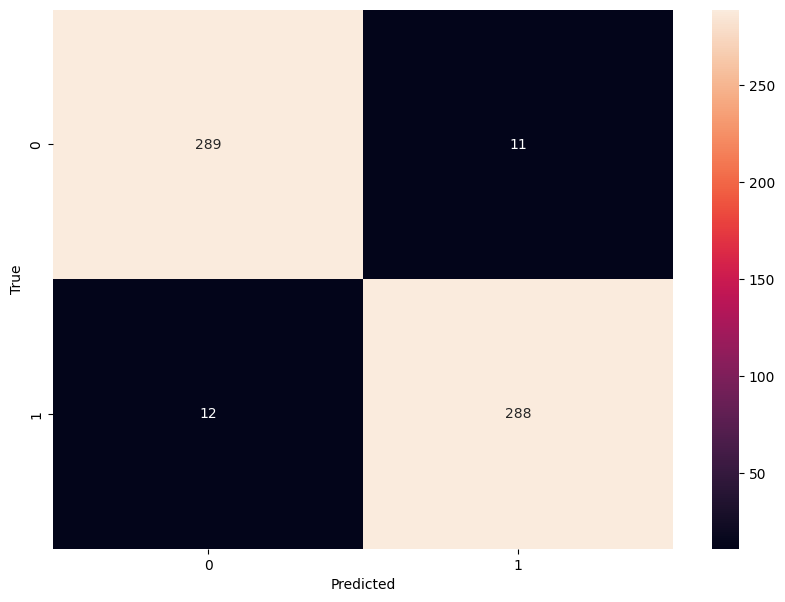

Accuracy: 96.17%


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

all_labels = []
all_predictions = []

for image, label in test_loader:
  image, label = image.to(device), label.to(device)

  with torch.no_grad(): # 학습 중이 아니므로 역전파를 위한 gradient 연산은 필요하지 않습니다
    pred = trained_model(image) # 순전파
    probabilities = torch.sigmoid(pred) # 시그모이드 함수를 이용해 확률 계산
    predicted = (probabilities > 0.5).float() # 확률을 레이블로 변환

    all_labels.extend(label.view(-1).cpu().numpy())
    all_predictions.extend(predicted.view(-1).cpu().numpy())

# Confusion matrix를 그려줍니다
cm = confusion_matrix(all_labels, all_predictions)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Accuracy도 출력해봅시다
accuracy = accuracy_score(all_labels, all_predictions)
print("Accuracy: {:.2f}%".format(accuracy * 100))